In [1]:
import pandas as pd
from functools import reduce
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Load df

In [2]:
Automated_data = pd.read_csv('AutomatedAnnotations_All.csv')
Annot_data = pd.read_csv('../1_manual/FinalManualLabels.csv')


In [3]:
Automated_data.head()

,datasetName,folderName,Image,Age,Gender,Race
0,AffectNet - Test,anger,image0000006,30,Woman,white
1,AffectNet - Test,anger,image0000060,34,Man,white
2,AffectNet - Test,anger,image0000061,44,Man,white
3,AffectNet - Test,anger,image0000066,49,Man,white
4,AffectNet - Test,anger,image0000106,30,Man,black


In [4]:
Annot_data.head()

,Image,FolderNames,Final_Age,Final_Gender,Final_Ethnicity
0,ffhq_0.png,neutral,Baby (0-1),Man,Latino/Hispanic
1,ffhq_10.png,happy,Middle-aged Adult (30-49),Woman,White
2,ffhq_107.png,neutral,Older Adult (50-65),Woman,White
3,ffhq_130.png,neutral,Child (2-9),Woman,Asian
4,ffhq_15.png,surprise,Young Adult (20-29),Man,White


# Merge Automated and Manual Annotations

In [5]:
# Clean and standardize the Annot_data
Annot_data.rename(columns={"Final_Age":"Manual_Age" , "Final_Gender":"Manual_Gender" , "Final_Ethnicity":"Manual_Ethnicity" , "FolderNames": "folderName"}, inplace=True)
Annot_data[''] = Annot_data['Image'].str.strip().str.lower()
Annot_data['folderName'] = Annot_data['folderName'].str.strip().str.lower()
Annot_data['Manual_Ethnicity'] = Annot_data['Manual_Ethnicity'].str.strip().str.lower()

# Remove '.jpg' and '.png' extensions from Annot_data image names
Annot_data['Image'] = Annot_data['Image'].str.replace('.jpg', '', regex=False).str.replace('.png', '', regex=False)

# Clean and standardize the Automated_data
Automated_data['Image'] = Automated_data['Image'].str.strip().str.lower()
Automated_data['folderName'] = Automated_data['folderName'].str.strip().str.lower()
Automated_data.rename(columns={"Age":"Automated_Age" , "Gender":"Automated_Gender" , "Race":"Automated_Ethnicity"}, inplace=True)

# Remove ' - Test' from datasetName in the Automated_data
Automated_data['datasetName'] = Automated_data['datasetName'].str.replace(' - Test', '', regex=False)

# Filter the Automated_data for 'AffectNet'
Automated_data_filtered = Automated_data[Automated_data['datasetName'] == 'AffectNet']

# Merge Annot_data and filtered Automated_data on Image
# and folderName
merged_data_filtered = pd.merge(
    Automated_data_filtered,
    Annot_data,
    on=["Image", "folderName"],
    how="inner"
)

# Rename columns as needed (e.g., Race to Ethnicity)
merged_data_filtered = merged_data_filtered.rename(columns={'Race': 'Automated_Ethnicity'})

# Map Ethnicity categories to standardize them
ethnicity_mapping = {
    'latino/hispanic': 'latino hispanic',
    'white': 'white',
    'asian': 'asian',
    'black': 'black',
    'indian': 'indian',
    'middle eastern': 'middle eastern',
    'ambiguous': None  # Handle ambiguous as NaN or ignore
}

# Align the ethnicity column in the merged dataset
merged_data_filtered['Manual_Ethnicity'] = merged_data_filtered['Manual_Ethnicity'].map(ethnicity_mapping)

# Define the age group function
def create_age_group(age):
    if age is None or age == '':
        return 'Unknown'  # Return 'Unknown' or any default label for missing values
    elif age < 2:
        return 'Baby (0-1)'
    elif 2 <= age < 10:
        return 'Child (2-9)'
    elif 10 <= age < 20:
        return 'Adolescent (10-19)'
    elif 20 <= age < 30:
        return 'Young Adult (20-29)'
    elif 30 <= age < 50:
        return 'Middle-aged Adult (30-49)'
    elif 50 <= age < 65:
        return 'Older Adult (50-65)'
    else:
        return 'Elderly (65+)'


# Apply the age group function to relevant columns
merged_data_filtered['Automated_Age'] = merged_data_filtered['Automated_Age'].apply(create_age_group)
merged_data = merged_data_filtered.copy()
merged_data.head()
# Optionally, save the merged data to a new CSV file
#merged_data.to_csv('merged_annotations_and_analysis.csv', index=False)


,datasetName,folderName,Image,Automated_Age,Automated_Gender,Automated_Ethnicity,Manual_Age,Manual_Gender,Manual_Ethnicity,
0,AffectNet,anger,image0001063,Middle-aged Adult (30-49),Woman,white,Baby (0-1),Man,white,image0001063.jpg
1,AffectNet,anger,image0003108,Middle-aged Adult (30-49),Man,middle eastern,Middle-aged Adult (30-49),Man,middle eastern,image0003108.jpg
2,AffectNet,contempt,image0006264,Young Adult (20-29),Woman,black,Young Adult (20-29),Woman,black,image0006264.jpg
3,AffectNet,contempt,image0013196,Older Adult (50-65),Man,asian,Elderly (65+),Man,asian,image0013196.jpg
4,AffectNet,contempt,image0019021,Middle-aged Adult (30-49),Woman,asian,Young Adult (20-29),Woman,asian,image0019021.jpg


# Access accuracy

In [6]:
df = merged_data.copy()
# Compare columns and calculate agreement
df['Age_Match'] = df['Manual_Age'] == df['Automated_Age']
df['Gender_Match'] = df['Manual_Gender'] == df['Automated_Gender']
df['Ethnicity_Match'] = df['Manual_Ethnicity'] == df['Automated_Ethnicity']

# Calculate overall agreement percentage for each attribute
age_accuracy = df['Age_Match'].mean() * 100
gender_accuracy = df['Gender_Match'].mean() * 100
ethnicity_accuracy = df['Ethnicity_Match'].mean() * 100

print(f"Age Agreement: {age_accuracy:.2f}%")
print(f"Gender Agreement: {gender_accuracy:.2f}%")
print(f"Ethnicity Agreement: {ethnicity_accuracy:.2f}%")


Age Agreement: 39.47%
Gender Agreement: 73.68%
Ethnicity Agreement: 73.68%


# Cohen's Kappa
Given that the manual annotations are considered ground truth and the automated system produces deterministic outputs (class labels), calculating Cohen's Kappa makes sense. It will evaluate the agreement between the automated system's predictions and the ground truth (manual annotations), while accounting for chance agreement.

In [7]:
# Replace NaN or None with 'Unknown' for all relevant columns
df['Manual_Age'] = df['Manual_Age'].fillna('Unknown')
df['Automated_Age'] = df['Automated_Age'].fillna('Unknown')
df['Manual_Gender'] = df['Manual_Gender'].fillna('Unknown')
df['Automated_Gender'] = df['Automated_Gender'].fillna('Unknown')
df['Manual_Ethnicity'] = df['Manual_Ethnicity'].fillna('Unknown')
df['Automated_Ethnicity'] = df['Automated_Ethnicity'].fillna('Unknown')


# Compute Cohen's Kappa for each attribute
age_kappa = cohen_kappa_score(df['Manual_Age'], df['Automated_Age'])
gender_kappa = cohen_kappa_score(df['Manual_Gender'], df['Automated_Gender'])
ethnicity_kappa = cohen_kappa_score(df['Manual_Ethnicity'], df['Automated_Ethnicity'])

# Print results
print(f"Age Cohen's Kappa: {age_kappa:.2f}")
print(f"Gender Cohen's Kappa: {gender_kappa:.2f}")
print(f"Ethnicity Cohen's Kappa: {ethnicity_kappa:.2f}")


Age Cohen's Kappa: 0.23
Gender Cohen's Kappa: 0.40
Ethnicity Cohen's Kappa: 0.68


# Plot

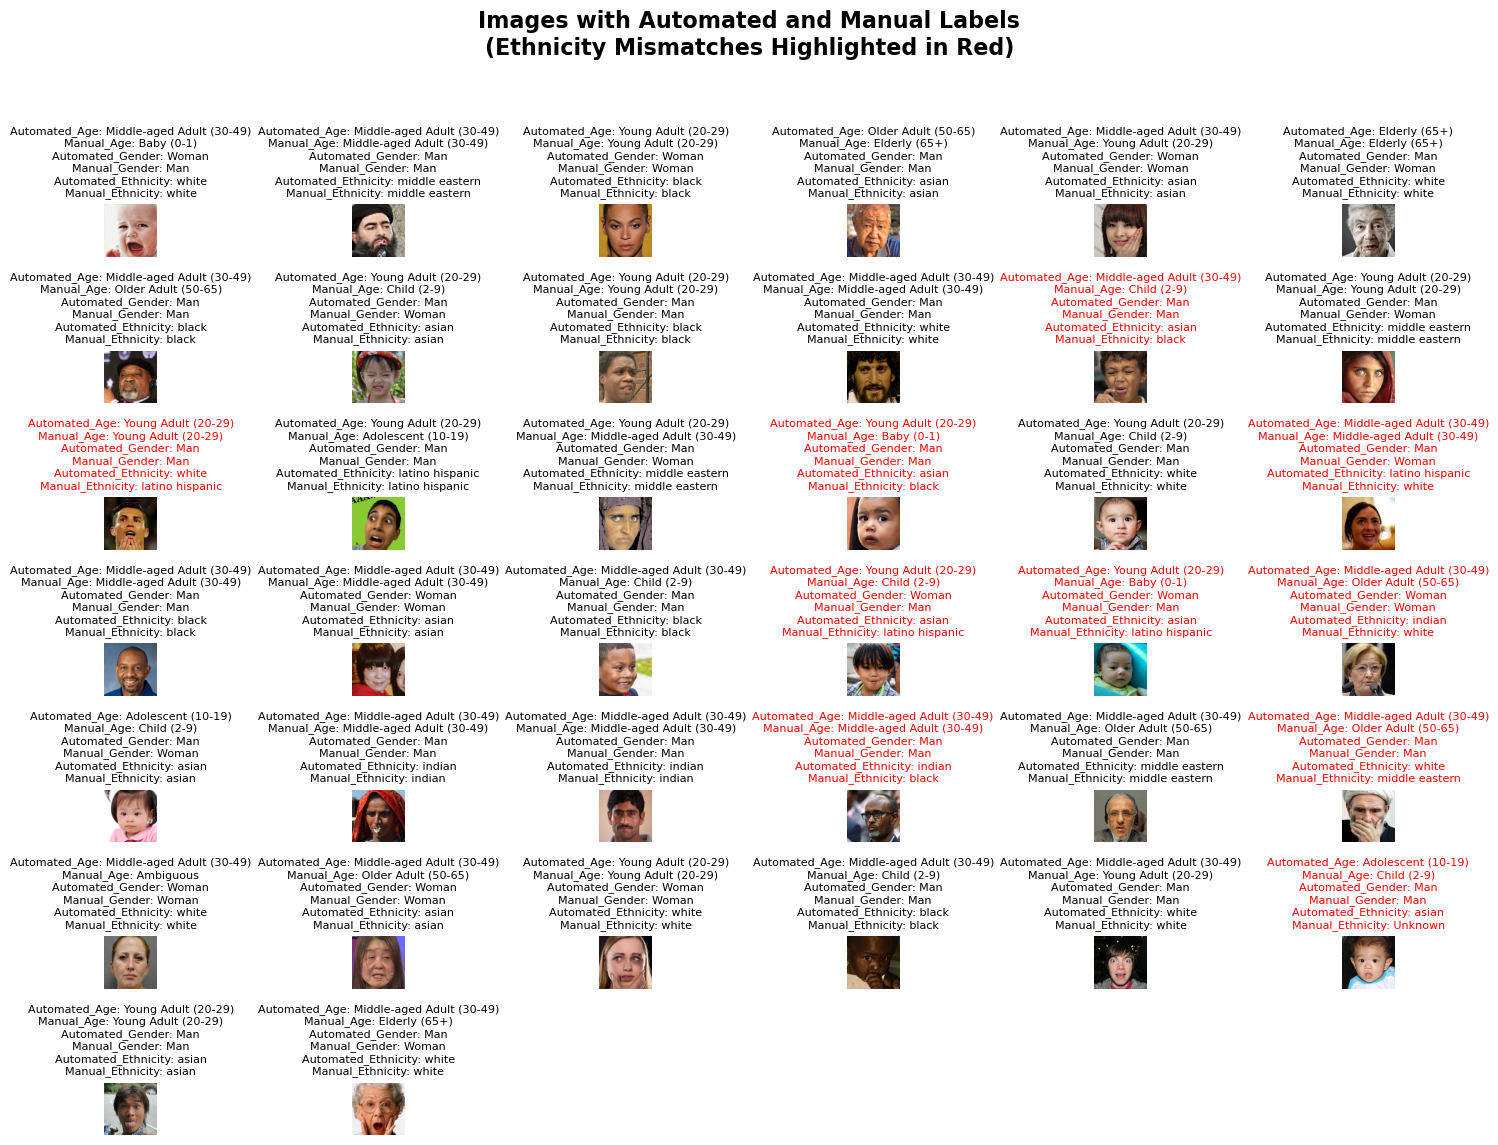

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set base directory path
base_dir = "../../3_image_datasets/affectnet/SelectionManualAnnotation/AffectNet"  # Replace with the actual path

# Set up the grid dimensions
fig, axes = plt.subplots(7, 6, figsize=(15, 12))  

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Track the index of the image we're displaying
for idx, (index, row) in enumerate(df.iterrows()):
    if idx >= 42:  # Stop after displaying 42 images (6x7 grid)
        break

    image_name = row["Image"]
    folder_name = row["folderName"]
    
    # Add file extension (.jpg or .png) if missing
    possible_extensions = [".jpg", ".png"]
    image_path = None
    for ext in possible_extensions:
        test_path = os.path.join(base_dir, folder_name, image_name + ext)
        if os.path.exists(test_path):
            image_path = test_path
            break

    # If the image file is not found, skip this row
    if not image_path:
        print(f"Image not found: {image_name} in folder {folder_name}")
        continue

    # Try to open the image file
    img = Image.open(image_path)

    # Display the image on the grid
    axes[idx].imshow(img)
    axes[idx].axis("off")
    
    # Prepare titles with both labels
    age = row["Automated_Age"]
    final_age = row["Manual_Age"]
    gender = row["Automated_Gender"]
    final_gender = row["Manual_Gender"]
    ethnicity = row["Automated_Ethnicity"]
    final_ethnicity = row["Manual_Ethnicity"]

    # Check for ethnicity mismatch
    if ethnicity != final_ethnicity:
        title_color = "red"  # Highlight mismatched labels in red
    else:
        title_color = "black"  # Matching labels in black

    # Add title with both sets of labels
    title = f"Automated_Age: {age}\nManual_Age: {final_age}\n" \
            f"Automated_Gender: {gender}\nManual_Gender: {final_gender}\n" \
            f"Automated_Ethnicity: {ethnicity}\nManual_Ethnicity: {final_ethnicity}"
    axes[idx].set_title(title, fontsize=8, color=title_color)

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

# Add a main title for the entire figure
fig.suptitle("Images with Automated and Manual Labels\n(Ethnicity Mismatches Highlighted in Red)", 
             fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

# Access Accuracy and Cohen's Kappa for JAFFE data

In [12]:

jaffe_data = Automated_data[Automated_data['datasetName'] == 'JAFFE']

# Define ground truth for JAFFE
ground_truth_gender = ['Woman'] * len(jaffe_data)
ground_truth_Ethnicity = ['asian'] * len(jaffe_data)

# Calculate Gender accuracy and Cohen's Kappa
gender_accuracy = accuracy_score(ground_truth_gender, jaffe_data['Automated_Gender'])
gender_kappa = cohen_kappa_score(ground_truth_gender, jaffe_data['Automated_Gender'])

# Calculate Ethnicity accuracy and Cohen's Kappa
Ethnicity_accuracy = accuracy_score(ground_truth_Ethnicity, jaffe_data['Automated_Ethnicity'])
Ethnicity_kappa = cohen_kappa_score(ground_truth_Ethnicity, jaffe_data['Automated_Ethnicity'])

# Display results
results = {
    "Gender Accuracy": gender_accuracy * 100,
    "Gender Kappa": gender_kappa,
    "Ethnicity Accuracy": Ethnicity_accuracy * 100,
    "Ethnicity Kappa": Ethnicity_kappa
}

results

{'Gender Accuracy': 43.66197183098591,
 'Gender Kappa': 0.0,
 'Ethnicity Accuracy': 86.3849765258216,
 'Ethnicity Kappa': 0.0}